# Simulador UNO

## Libraries


In [104]:
import copy
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Environment

In [105]:
bots_list = ["Júlio", "Bia", "Douglas", "Daniel", "Jorge", "Rodrigo", "Gabrielle", "Patrick", "Cesar"]

#Definindo o baralho original como uma constante para ser copiada em cada simulação
ORIGINAL_FULL_DECK = {
    "red": ["0", "1", "1", "2", "2", "3", "3", "4", "4", "5", "5", "6", "6", "7", "7", "8", "8", "9", "9", "reverse", "reverse", "skip", "skip", "+2", "+2"],
    "blue": ["0", "1", "1", "2", "2", "3", "3", "4", "4", "5", "5", "6", "6", "7", "7", "8", "8", "9", "9", "reverse", "reverse", "skip", "skip", "+2", "+2"],
    "yellow": ["0", "1", "1", "2", "2", "3", "3", "4", "4", "5", "5", "6", "6", "7", "7", "8", "8", "9", "9", "reverse", "reverse", "skip", "skip", "+2", "+2"],
    "green": ["0", "1", "1", "2", "2", "3", "3", "4", "4", "5", "5", "6", "6", "7", "7", "8", "8", "9", "9", "reverse", "reverse", "skip", "skip", "+2", "+2"],
    "special": ["+4", "+4", "+4", "+4", "wild", "wild", "wild", "wild"]
}

fullDeck = {}
mount = {}

class Player:
    def __init__(self, category, name, hand, strategy_function=None):
        self.category = category
        self.name = name
        self.hand = hand
        self.turn = 0
        #Armazena a função da estratégia diretamente
        self.strategy_function = strategy_function
        #Armazena o nome da estratégia para fácil referência nos resultados
        self.strategy_name = strategy_function.__name__ if strategy_function else "random"
        self.pushCards = 0

class Card:
	def __init__(self, color, number):
		self.color = color
		self.number = number

## Informations

In [106]:
def print_deck(currentPlayer):
    print(currentPlayer.name, " Cards in Hand:")

    #Dicionário para agrupar as cartas por cor
    cards_by_color = {
        "red": [],
        "green": [],
        "blue": [],
        "yellow": [],
        "special": []
    }

    #Preenche o dicionário com as cartas do jogador
    for card in currentPlayer.hand:
        if card.color in cards_by_color:
            cards_by_color[card.color].append(card.number)
        else:
            #Caso haja alguma cor inesperada, trata como special ou cria nova categoria
            cards_by_color["special"].append(f"{card.color} {card.number}")

    #Imprime as cartas de forma tabulada
    print(f"{'red':<10} / {'green':<10} / {'blue':<10} / {'yellow':<10} / {'special':<10}")
    print(f"{'-'*10} / {'-'*10} / {'-'*10} / {'-'*10} / {'-'*10}")

    #Encontra o número máximo de cartas em qualquer categoria para iteração
    max_cards_in_any_color = 0
    for color_list in cards_by_color.values():
        if len(color_list) > max_cards_in_any_color:
            max_cards_in_any_color = len(color_list)

    #Itera para imprimir as cartas linha por linha
    for i in range(max_cards_in_any_color):
        row_output = []
        for color_key in ["red", "green", "blue", "yellow", "special"]:
            if i < len(cards_by_color[color_key]):
                row_output.append(f"{cards_by_color[color_key][i]:<10}")
            else:
                row_output.append(f"{'':<10}")
        print(" / ".join(row_output))

    print("\nMountain Cards:")
    print(mount)
    print("\n")

#def winner(bot_winner, startTime):
#	print("|----------------------------------")
#	print("| Game Finish!\n|")
#	print(f"| Winner is - {bot_winner.name}")
#	print("| Congratulations!!! 🎉🎊🎊\n|")
#	print("|",time.time() - startTime, "seconds!")
#	print(f"| in {bot_winner.turn} turns")
#	print("|----------------------------------\n")

#def end_the_game():
#	print("|----------------------------------")
#	print("| Game finished!\n|")
#	print("No cards in deck\n")
#	print("|----------------------------------\n")
#	exit()

def winner(bot_winner, startTime, activeBots):
    return {
        "status": "Vencedor",
        "vencedor_nome": bot_winner.name,
        "vencedor_estrategia": bot_winner.strategy_name,
        "turnos_vencedor": bot_winner.turn,
        "cartas_puxadas": bot_winner.pushCards,
        "tempo_s": time.time() - startTime,
        "estrategias_jogadores": {p.name: p.strategy_name for p in activeBots},
        "cartas_finais": {p.name: len(p.hand) for p in activeBots}
    }

def end_the_game(startTime, activeBots):
    return {
        "status": "Baralho Vazio",
        "vencedor_nome": None,
        "vencedor_estrategia": None,
        "turnos_vencedor": None,
        "tempo_s": time.time() - startTime,
        "estrategias_jogadores": {p.name: p.strategy_name for p in activeBots},
        "cartas_finais": {p.name: len(p.hand) for p in activeBots}
    }

## Player

In [107]:
def push_hand(CardCount):
	hand = []
	for i in range(CardCount):
		hand.append(push_card())
	return hand

def push_card():
    global fullDeck, mount

    if len(fullDeck) == 0 and len(mount) > 0:
        fullDeck.update(mount)
        mount.clear()
    elif len(fullDeck) == 0 and len(mount) == 0:
        end_the_game()

    selection = [random.choice(list(fullDeck.keys()))]
    selection.append(random.choice(fullDeck[selection[0]]))

    fullDeck[selection[0]].remove(selection[1])
    if len(fullDeck[selection[0]]) == 0:
        del fullDeck[selection[0]]

    return Card(selection[0], selection[1])

def played_card(currentPlayer, selectedCard):
	currentPlayer.hand.remove(selectedCard)
	mount_deck(selectedCard)

#Função auxiliar para avaliar o "peso" da carta para estratégias de valor
def get_card_weight(card):
    if card.color == "special":
        if card.number == "+4":
            return 5 #Maior peso para +4
        elif card.number == "wild":
            return 4 #Segundo maior peso para Coringa
    elif card.number in ["+2", "reverse", "skip"]:
        return 3 #Peso para cartas de ação
    else:
        return 1 #Menor peso para cartas normais (números)

def decide_wild_card_color(currentPlayer):
    """
    Decide a cor para uma carta Wild (+4 ou wild) com base:
    1. Na cor mais frequente no 'mount' (pilha de descarte).
    2. Se o jogador tem cartas dessa cor na mão.
    Se não tiver, tenta a segunda cor mais frequente e assim por diante.
    Se não tiver nenhuma das cores mais frequentes do mount, escolhe a cor mais abundante na própria mão.
    """

    #1. Contar a frequência das cores no 'mount'
    mount_color_counts = {"red": 0, "blue": 0, "yellow": 0, "green": 0}
    for color, numbers in mount.items():
        if color in mount_color_counts: #Ignora 'special' ao contar frequências de cores base
            mount_color_counts[color] += len(numbers)

    #Ordenar as cores do mount pela frequência, da maior para a menor
    sorted_mount_colors = sorted(mount_color_counts.items(), key=lambda item: item[1], reverse=True)

    #2. Contar a frequência das cores na mão do jogador
    player_hand_color_counts = {"red": 0, "blue": 0, "yellow": 0, "green": 0}
    for card in currentPlayer.hand:
        if card.color in player_hand_color_counts:
            player_hand_color_counts[card.color] += 1

    #3. Iterar pelas cores mais frequentes do 'mount' e verificar a mão do jogador
    for color, _ in sorted_mount_colors:
        if player_hand_color_counts[color] > 0 and mount_color_counts[color] > 0:
            return color #Retorna a primeira cor do mount que o jogador tem na mão

    #4. Se o jogador não tiver nenhuma das cores do mount na mão,
    #então escolhe a cor mais abundante na própria mão (excluindo especiais)
    most_common_hand_color = None
    max_count = -1
    for color, count in player_hand_color_counts.items():
        if count > max_count:
            max_count = count
            most_common_hand_color = color

    if most_common_hand_color:
        return most_common_hand_color

    #5. Se, por algum motivo, a mão está vazia de cores normais ou não foi possível decidir,
    #retorna uma cor aleatória como fallback
    return random.choice(["red", "blue", "yellow", "green"])

#Estratégia Ofensiva(1)
#Foca no uso proativo de cartas de ação e especiais para limitar opções do oponente.
#Prioriza jogar cartas de maior peso (especiais, ação) o mais rápido possível.
def strategy_offensive(currentPlayer, currentCard, playableCards, activeBots):
    if not playableCards:
        return None #Sem cartas para jogar, deve comprar

    #Prioridade 1: Cartas +4
    plus4_cards = [card for card in playableCards if card.color == "special" and card.number == "+4"]
    if plus4_cards:
        return random.choice(plus4_cards) #Joga qualquer +4 disponível

    #Prioridade 2: Coringas (wild)
    wild_cards = [card for card in playableCards if card.color == "special" and card.number == "wild"]
    if wild_cards:

        return random.choice(wild_cards)

    #Prioridade 3: Cartas de Ação (+2, reverse, skip)
    action_cards = [card for card in playableCards if card.number in ["+2", "reverse", "skip"]]
    if action_cards:
        return random.choice(action_cards) #Joga qualquer carta de ação disponível

    #Prioridade 4: Cartas normais (se nada acima estiver disponível)
    normal_cards = [card for card in playableCards if card.color != "special" and card.number not in ["+2", "reverse", "skip"]]
    if normal_cards:
        return random.choice(normal_cards)

    return None #Return de segurança, caso nenhuma das cartas seja jogavel.


#Estratégia de Conservação(2)
#Prioriza guardar cartas poderosas (+4, Coringas) para momentos decisivos.
#Tenta jogar cartas normais primeiro, depois cartas de ação, por último as especiais.
def strategy_conservation(currentPlayer, currentCard, playableCards, activeBots):
    if not playableCards:
        return None #Sem cartas para jogar, deve comprar

    #Prioridade 1: Cartas normais (descartar primeiro)
    normal_cards = [card for card in playableCards if card.color != "special" and card.number not in ["+2", "reverse", "skip"]]
    if normal_cards:
        return random.choice(normal_cards)

    #Prioridade 2: Cartas de Ação (+2, reverse, skip)
    action_cards = [card for card in playableCards if card.number in ["+2", "reverse", "skip"]]
    if action_cards:
        return random.choice(action_cards)

    #Prioridade 3: Coringas (wild) e +4 (guardar ao máximo, só usar se for a única opção)
    special_cards = [card for card in playableCards if card.color == "special"]
    if special_cards:
        return random.choice(special_cards)

    return None #Nenhuma carta para jogar

#Estratégia de Descarte Otimizado(3)
#Prioriza descartar cartas que se repetem em número ou cor, ou usar Reverse para otimizar.
def strategy_optimized_discard(currentPlayer, currentCard, playableCards, activeBots):
    if not playableCards:
        return None

    #Prioridade 1: Cartas Reverse (se o jogo for de mais de 2 jogadores) para ganhar um turno ou inverter a vez de um oponente "perigoso"
    reverse_cards = [card for card in playableCards if card.number == "reverse"]
    if reverse_cards and len(activeBots) > 2: #Só faz sentido em jogos com mais de 2 jogadores
        return random.choice(reverse_cards)

    #Prioridade 2: Cartas normais que combinam com a cor ou número
    #Tenta jogar uma carta que não seja especial ou ação, mas que ainda combine
    normal_matching_cards = [card for card in playableCards if card.color != "special" and card.number not in ["+2", "reverse", "skip"]]
    if normal_matching_cards:
        #Poderia ser a carta de maior valor numérico para descartar rápido
        #Ou a carta que o bot tem mais cópias de cor/número para se livrar do tipo
        return random.choice(normal_matching_cards)

    #Prioridade 3: Outras cartas (ações, especiais) se não tiver opções acima
    return random.choice(playableCards) if playableCards else None

## Table

In [108]:
def mount_deck(Card):
    global mount
    if Card.color not in mount:
        mount[Card.color] = []
    mount[Card.color].append(Card.number)

def ability_card(direction, selectedCard, currentPlayer, nextPlayer, activeBots):
    jump = False
    original_color = selectedCard.color

    if selectedCard.color == "special":
        new_color = decide_wild_card_color(currentPlayer)
        #Cria um novo objeto de carta para a pilha de descarte com a nova cor
        discard_card = Card(new_color, selectedCard.number)
        if selectedCard.number == "+4":
            new_hand = push_hand(4)
            if new_hand is None: return None, None, None
            nextPlayer.hand += new_hand
            nextPlayer.pushCards += 4
            jump = True #Na regra oficial, +4 pula a vez

    elif selectedCard.number == "+2":
        new_hand = push_hand(2)
        if new_hand is None: return None, None, None
        nextPlayer.hand += new_hand
        nextPlayer.pushCards += 2
        jump = True
    elif selectedCard.number == "reverse":
        if len(activeBots) > 2:
            direction *= -1
        else: #Em jogo de 2 pessoas, reverse funciona como skip
            jump = True
    elif selectedCard.number == "skip":
        jump = True

    #A carta que vai para a pilha de descarte
    currentCard = discard_card if original_color == "special" else selectedCard

    if jump:
        next_player_index = (activeBots.index(currentPlayer) + (2 * direction)) % len(activeBots)
        nextPlayer = activeBots[next_player_index]
    else:
        next_player_index = (activeBots.index(currentPlayer) + direction) % len(activeBots)
        nextPlayer = activeBots[next_player_index]

    return currentCard, nextPlayer, direction

def finishTurn_with_selected_card(direction, selectedCard, currentPlayer, nextPlayer, currentCard, activeBots):
    played_card(currentPlayer, selectedCard)
    print(currentPlayer.name, "played", selectedCard.color, selectedCard.number, "\n")

    #Aplicando o efeito da carta selecionada
    selectedCard, nextPlayer, direction = ability_card(direction, currentCard, selectedCard, currentPlayer, nextPlayer, activeBots)

    currentCard = selectedCard

    return nextPlayer, currentCard


def bot_play(direction, currentPlayer, currentCard, activeBots):
    currentPlayer.turn += 1

    playableCards = [card for card in currentPlayer.hand if card.color == currentCard.color or card.number == currentCard.number or card.color == "special"]

    selectedCard = None
    if currentPlayer.strategy_function and playableCards:
        selectedCard = currentPlayer.strategy_function(currentPlayer, currentCard, playableCards, activeBots)
    elif playableCards: #Fallback para aleatório se não houver estratégia
        selectedCard = random.choice(playableCards)

    if selectedCard:
        played_card(currentPlayer, selectedCard)
        currentCard, nextPlayer, new_direction = ability_card(direction, selectedCard, currentPlayer, activeBots[(activeBots.index(currentPlayer) + direction) % len(activeBots)], activeBots)
        if currentCard is None: #Checa se o jogo acabou
            return None, None, None
        return nextPlayer, currentCard, new_direction
    else:
        new_card = push_card()
        if new_card is None:
             return None, None, None
        currentPlayer.hand.append(new_card)
        currentPlayer.pushCards += 1
        #O turno passa para o próximo jogador após comprar
        nextPlayer = activeBots[(activeBots.index(currentPlayer) + direction) % len(activeBots)]
        return nextPlayer, currentCard, direction


def start(activeBots, delay, startTime):
    global fullDeck, mount
    currentCard = push_card()
    if currentCard is None: return end_the_game(startTime, activeBots)

    while currentCard.color == "special":
        mount_deck(currentCard)
        fullDeck.update(mount); mount.clear()
        currentCard = push_card()
        if currentCard is None: return end_the_game(startTime, activeBots)

    mount_deck(currentCard)

    currentPlayer = activeBots[0]
    direction = 1

    while True:
        nextPlayer_before_ability = activeBots[(activeBots.index(currentPlayer) + direction) % len(activeBots)]
        currentPlayer.turn += 1
        playableCards = [c for c in currentPlayer.hand if c.color == currentCard.color or c.number == currentCard.number or c.color == "special"]

        selectedCard = None
        if playableCards:
             if currentPlayer.strategy_function:
                 selectedCard = currentPlayer.strategy_function(currentPlayer, currentCard, playableCards, activeBots)
             else:
                 selectedCard = random.choice(playableCards)

        if selectedCard:
            played_card(currentPlayer, selectedCard)
            _, nextPlayer, new_direction = ability_card(direction, selectedCard, currentPlayer, nextPlayer_before_ability, activeBots)
            currentCard = selectedCard
            if selectedCard.color == 'special':
                 currentCard = Card(decide_wild_card_color(currentPlayer), selectedCard.number)
            direction = new_direction
        else:
            new_card = push_card()
            if new_card is None: return end_the_game(startTime, activeBots)
            currentPlayer.hand.append(new_card)
            currentPlayer.pushCards += 1
            nextPlayer = nextPlayer_before_ability

        if len(currentPlayer.hand) == 0:
            return winner(currentPlayer, startTime, activeBots)

        currentPlayer = nextPlayer

## First Screen

In [109]:
def welcome():
  print("Welcome to Uno Simulator(Version 2.0)!!!\n")
  while True:
    #if input("Type 'start' to begin!\n").lower()  == "start":
      startup()
      break
    #else:
    #  print("Type something valid!")

def startup():
  cardCount = int(input("Enter the number of cards in hand: "))
  numberOfBots = int(input("Enter number of bots(Maximum 10): "))
  delay = int(input("the number of seconds between plays: "))
  print("\n")
  startTime = time.time()
  activeBots = []

  for x in range(numberOfBots):
    activeBots.append(Player("bot", bots[x], push_hand(cardCount), strategy_conservation))

  if numberOfBots == 1:
    winner(activeBots[0], startTime)
  else:
    start(activeBots, delay, startTime)

## Main Route

In [110]:
#Monte Carlo Simulation
def rodar_simulacoes(num_simulacoes, num_bots, estrategias, num_cartas_iniciais):
    global fullDeck, mount
    all_results = []

    print(f"Iniciando {num_simulacoes} simulações com {num_bots} bots...")

    for i in range(num_simulacoes):
        fullDeck = copy.deepcopy(ORIGINAL_FULL_DECK)
        mount.clear()

        activeBots = []
        try:
            for j in range(num_bots):
                bot_name = bots_list[j]
                strategy_func = estrategias[j % len(estrategias)]
                initial_hand = push_hand(num_cartas_iniciais)
                activeBots.append(Player("bot", bot_name, initial_hand, strategy_func))
        except Exception:
            continue

        startTime = time.time()
        result = start(activeBots, 0, startTime) #O delay é 0 para simulações rápidas
        all_results.append(result)

        if (i + 1) % (num_simulacoes // 10 or 1) == 0:
            print(f"Simulações concluídas: {i + 1}/{num_simulacoes}")

    return all_results

#Main Execution (O CÓDIGO TEM 2 VERSÕES, A PRIMEIRA FOI A CRIAÇÃO DO SISTEMA DO JOGO UNO AFIM DE VISUALIZAR AS MECANICAS E OS BOTS JOGANDO, ASSIM COMO VERIFICAÇÃO DE ERROS, POSTERIOR CRIAMOS A VERSÃO QUE REALIZA OS TESTES DE MONTE CARLO)
if __name__ == "__main__":
    NUMERO_DE_SIMULACOES = 10000
    NUMERO_DE_BOTS = 9
    CARTAS_POR_JOGADOR = 7

    ESTRATEGIAS_PARA_TESTAR = [strategy_offensive, strategy_conservation, strategy_optimized_discard]

    if NUMERO_DE_BOTS != len(ESTRATEGIAS_PARA_TESTAR):
        print("Aviso: O número de bots não corresponde ao número de estratégias. As estratégias serão repetidas.")

    #Roda a simulação de Monte Carlo
    resultados = rodar_simulacoes(NUMERO_DE_SIMULACOES, NUMERO_DE_BOTS, ESTRATEGIAS_PARA_TESTAR, CARTAS_POR_JOGADOR)

    #Converte os resultados para um DataFrame do Pandas
    df_resultados = pd.DataFrame(resultados)

    #Salva os resultados em um arquivo CSV
    nome_arquivo_saida = "resultados_simulacaoUNO_10000x9.csv"
    df_resultados.to_csv(nome_arquivo_saida, index=False, encoding='utf-8-sig')

    print("\n--- Simulação Concluída ---")
    print(f"Os resultados foram salvos em: {nome_arquivo_saida}")

    #Mostra um resumo dos resultados
    print("\n--- Resumo dos Resultados ---")
    if not df_resultados.empty and 'vencedor_estrategia' in df_resultados.columns:
        contagem_vitorias = df_resultados['vencedor_estrategia'].value_counts(dropna=True)
        print("Contagem de vitórias por estratégia:")
        print(contagem_vitorias)

        taxa_vitoria = df_resultados['vencedor_estrategia'].value_counts(normalize=True, dropna=True).map('{:.2%}'.format)
        print("\nTaxa de vitória (%):")
        print(taxa_vitoria)

        print("\nEstatísticas de Turnos por Estratégia Vencedora:")
        print(df_resultados.groupby('vencedor_estrategia')['turnos_vencedor'].describe())
    else:
        print("Não foi possível gerar um resumo dos resultados.")

    print("\n--- Amostra dos Dados Coletados ---")
    print(df_resultados.head())

Aviso: O número de bots não corresponde ao número de estratégias. As estratégias serão repetidas.
Iniciando 10000 simulações com 9 bots...
Simulações concluídas: 1000/10000
Simulações concluídas: 2000/10000
Simulações concluídas: 3000/10000
Simulações concluídas: 4000/10000
Simulações concluídas: 5000/10000
Simulações concluídas: 6000/10000
Simulações concluídas: 7000/10000
Simulações concluídas: 8000/10000
Simulações concluídas: 9000/10000
Simulações concluídas: 10000/10000

--- Simulação Concluída ---
Os resultados foram salvos em: resultados_simulacaoUNO_10000x9.csv

--- Resumo dos Resultados ---
Contagem de vitórias por estratégia:
vencedor_estrategia
strategy_optimized_discard    3859
strategy_conservation         3295
strategy_offensive            2846
Name: count, dtype: int64

Taxa de vitória (%):
vencedor_estrategia
strategy_optimized_discard    38.59%
strategy_conservation         32.95%
strategy_offensive            28.46%
Name: proportion, dtype: object

Estatísticas de Tur

# Estudo Estatístico das Estratégias


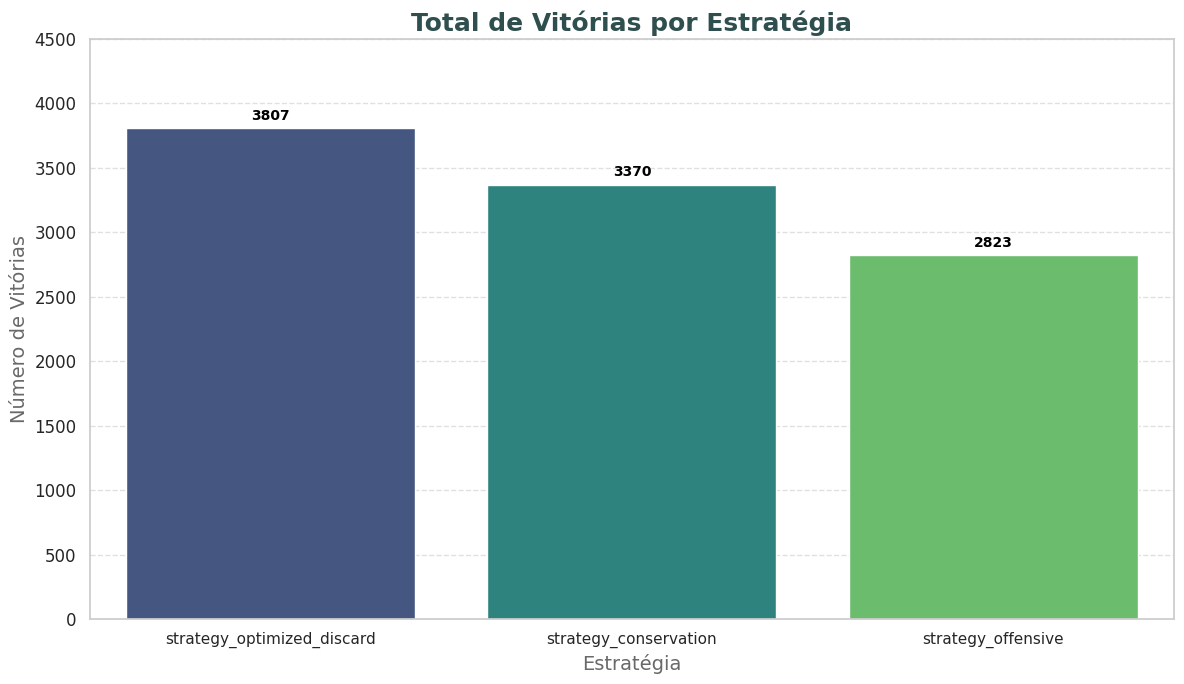

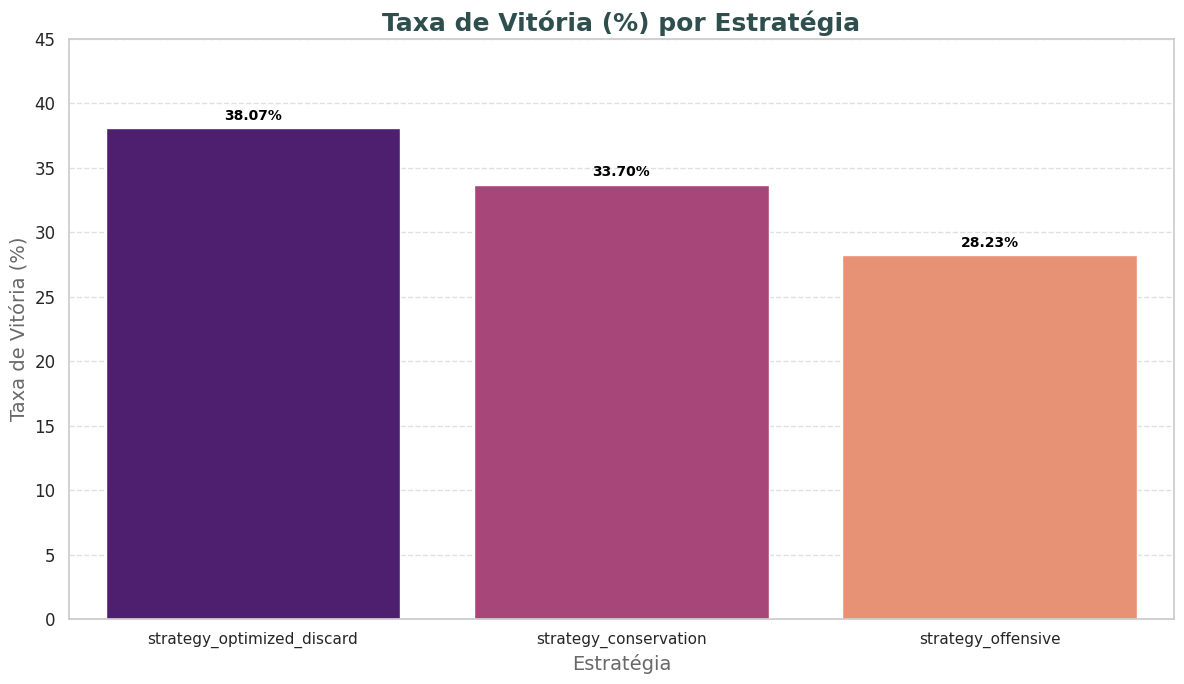

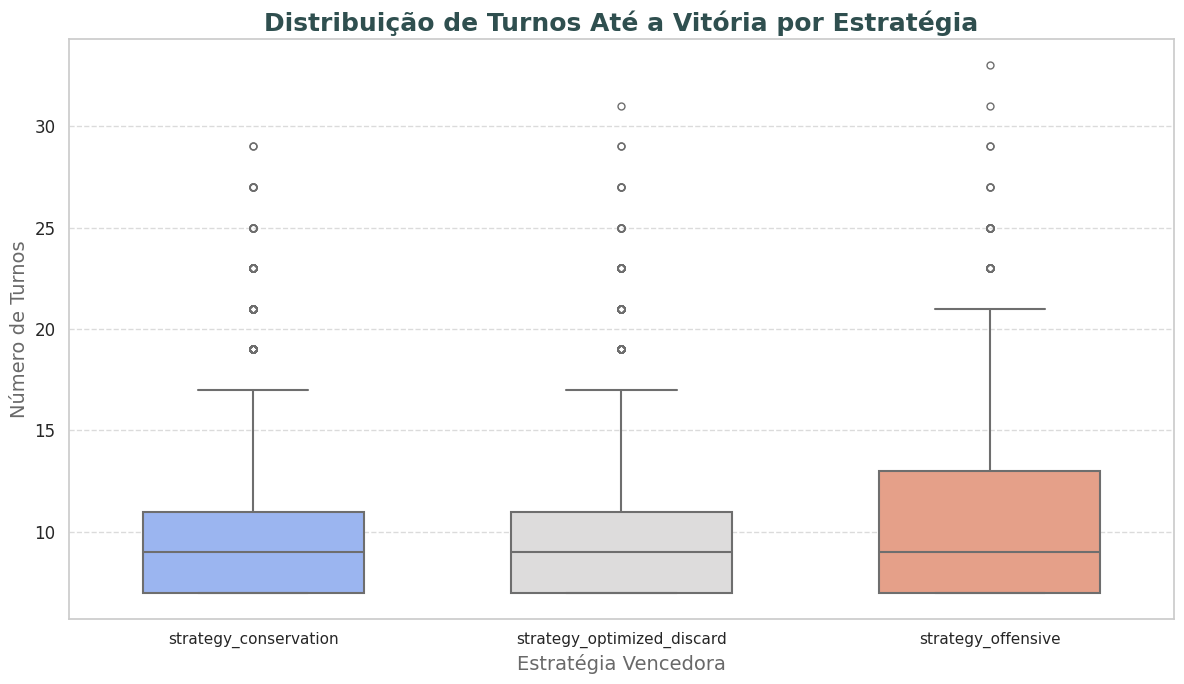

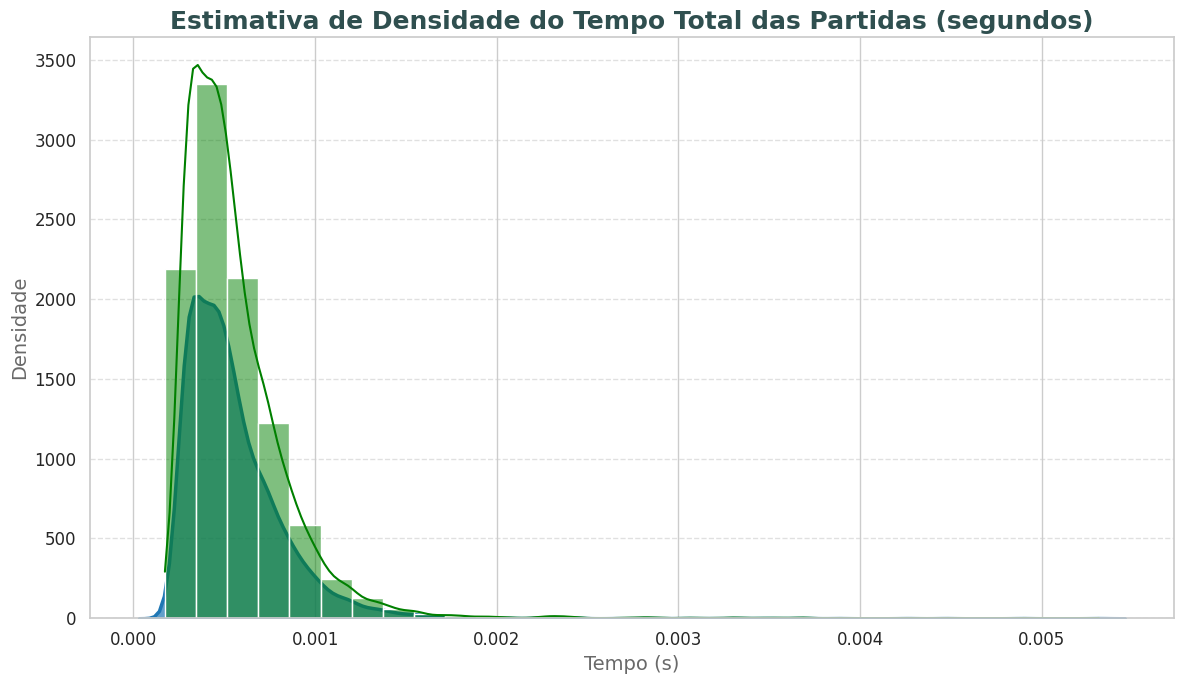

In [112]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/resultados_simulacaoUNO_10000x9.csv')

# Estilo dos gráficos (darkgrid, whitegrid, dark, white, ticks)
sns.set_style("whitegrid") # Estilo mais moderno e visualmente atraente

# Contagem total de vitórias por estratégia
contagem_vitorias = df['vencedor_estrategia'].value_counts()

# Taxa de vitória (porcentagem)
taxa_vitoria = df['vencedor_estrategia'].value_counts(normalize=True) * 100

# --- Gráfico 1: Quantidade de Vitórias por Estratégia ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=contagem_vitorias.index, y=contagem_vitorias.values,
                    hue=contagem_vitorias.index, palette='viridis', legend=False)
plt.title('Total de Vitórias por Estratégia', fontsize=18, fontweight='bold', color='darkslategray')
plt.xlabel('Estratégia', fontsize=14, color='dimgray')
plt.ylabel('Número de Vitórias', fontsize=14, color='dimgray')
plt.yticks(fontsize=12)
plt.ylim(top=4500)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adiciona os rótulos de valor nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# --- Gráfico 2: Taxa de Vitória (%) por Estratégia ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=taxa_vitoria.index, y=taxa_vitoria.values,
                    hue=taxa_vitoria.index, palette='magma', legend=False)
plt.title('Taxa de Vitória (%) por Estratégia', fontsize=18, fontweight='bold', color='darkslategray')
plt.xlabel('Estratégia', fontsize=14, color='dimgray')
plt.ylabel('Taxa de Vitória (%)', fontsize=14, color='dimgray')
plt.yticks(fontsize=12)
plt.ylim(top=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adiciona os rótulos de porcentagem nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# --- Gráfico 3: Distribuição de Turnos Até a Vitória por Estratégia (Boxplot) ---
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='vencedor_estrategia', y='turnos_vencedor',
            hue='vencedor_estrategia', palette='coolwarm', legend=False,
            linewidth=1.5, fliersize=5,  # Linha e tamanho dos outliers
            width=0.6) # Largura das caixas
plt.title('Distribuição de Turnos Até a Vitória por Estratégia', fontsize=18, fontweight='bold', color='darkslategray')
plt.xlabel('Estratégia Vencedora', fontsize=14, color='dimgray')
plt.ylabel('Número de Turnos', fontsize=14, color='dimgray')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Gráfico 4: Distribuição do Tempo Total das Partidas (KDE Plot) ---
if 'tempo_s' in df.columns:
    plt.figure(figsize=(12, 7))
    sns.kdeplot(df['tempo_s'], fill=True, color='#1f77b4', linewidth=2.5,  # Cor e preenchimento
                alpha=0.7) # Transparência
    sns.histplot(df['tempo_s'], bins=30, kde=True, color='green')
    plt.title('Estimativa de Densidade do Tempo Total das Partidas (segundos)', fontsize=18, fontweight='bold', color='darkslategray')
    plt.xlabel('Tempo (s)', fontsize=14, color='dimgray')
    plt.ylabel('Densidade', fontsize=14, color='dimgray')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'tempo_s' não encontrada para gerar o gráfico de tempo.")